In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sn

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, ne_chunk

In [17]:
DATA_DIR = '../data/'
TOOLS_DIR = '../tools/'
FILENAME = 'AllDiscussionDataCODED_USE_THIS_14Feb2020_MH.xls'
LEMMASFILE = DATA_DIR + 'tmp.output'

data = pd.read_excel( io = DATA_DIR + FILENAME ).dropna('index', 'all').dropna('columns', 'all')
# data = data.reset_index()
with open( DATA_DIR + 'stopwords-sl.txt', mode='r', encoding='utf-8') as f:
    stopwordsSLO = f.read().split( '\n' )

In [18]:
def parseLemmas( filename ):
    lemmas = []
    with open( filename, mode = 'r', encoding ='utf-8' ) as f:
        for l in f.readlines():
            line = l.strip()
            if line.startswith( '#' ):
                if line.startswith( '# newpar id =' ):
                    lemmas.append( [ ] )
                else:
                    continue
            tmp = line.split( '\t' )
            if len( tmp ) > 1:
                lemmas[ -1 ].append( tmp[ 2 ] )
#     return pd.Series( lemmas, indexes )
    return lemmas

def writeMessages( msgs ):
    with open( DATA_DIR + 'tmp.input', 'w', encoding='utf-8' ) as f:
        for line in msgs:
            f.write( str( line ) + '\n' )

def prepareTokens():
    command = 'cat {0}tmp.input | python {1}tokeniser.py sl -n -c -d > {2}'.format( DATA_DIR, TOOLS_DIR + 'reldi-tokeniser-master/', DATA_DIR + 'tmp.conllu' )
    print( 'Running command ', command )
    !$command
    
def prepareLemmas():
    command = 'cd {0} python -m stanfordnlp.models.lemmatizer --model_dir models/lemma/ --model_file ssj500k+Sloleks --eval_file {1} --output_file {2} --mode predict; cd --;'.format( '../tools/classla-stanfordnlp-master;', '../../data/tmp.conllu', '../../data/tmp.output' )
    !$command
    
def lemmatize( messages ):
    writeMessages()
    prepareTokens()
    prepareLemmas()
    lemmas = parseLemmas( LEMMASFILE )
    return lemmas

In [19]:
class LemmaTokenizer( object ):
    def __init__( self ):
        self.wnl = WordNetLemmatizer()
        
    def __call__( self, articles ):
        return [ self.wnl.lemmatize( t ) for t in word_tokenize( articles ) if self.wnl.lemmatize( t ) not in stopwordsSLO ]

In [20]:
data.drop( data[ pd.isna( data[ 'Message' ] ) == True ].index, inplace = True ) # remove rows with empty message
data.drop( data[ pd.isna( data[ 'Book relevance' ] ) == True ].index, inplace = True ) # remove rows with unknown book relevance

# some additional preprocessing

In [21]:
# print( len( data[ pd.isna( data[ 'Message' ] ) == True ] ) )
# print( len( data[ pd.isna( data[ 'Book relevance' ] ) == True ] ) )
X_trainO, X_testO, y_trainO, y_testO = train_test_split( data[ 'Message' ], data[ 'Book relevance' ], random_state = 42 )
# writeMessages( X_trainO )
# prepareTokens()
# prepareLemmas()
lemmas = parseLemmas( LEMMASFILE )

In [22]:
x_relevant = len( X_trainO[ ( data[ 'Book relevance' ] == 'Yes' ) ] )
x_nonrelevant = len( X_trainO[ ( data[ 'Book relevance' ] == 'No' ) ] )
testNonRelevant = len( X_testO[ ( data[ 'Book relevance' ] == 'No' ) ] )
print( 'Book relevant texts in training set: {0}'.format( x_relevant ) )
print( 'Book non-relevant texts in training set: {0}'.format( x_nonrelevant ) )
print( 'Baseline classifier accuracy on training set: {0}'.format( x_nonrelevant / len( X_trainO ) ) )
print( 'Baseline classifier accuracy on test set: {0}'.format( testNonRelevant / len( X_testO ) ) )

Book relevant texts in training set: 1047
Book non-relevant texts in training set: 1606
Baseline classifier accuracy on training set: 0.605352431209951
Baseline classifier accuracy on test set: 0.6192090395480226


In [32]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
import numpy as np
import random

class MeasureFeatures(BaseEstimator):

    def __init__(self):
        pass

    def get_feature_names(self):
        return np.array(['length', 'contains_question_mark', 'contains_exclamation_mark'])

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        
        X_length = list()
        X_contains_question_mark = list()
        X_contains_exclamation_mark = list()
        
        for sentence in x_dataset:
            
            X_length.append(len(sentence))
            X_contains_question_mark.append(1 if str(sentence).find("?") != -1 else 0)
            X_contains_exclamation_mark.append(1 if str(sentence).find("!") != -1 else 0)

            # takes pos tag text and counts number of noun pos tags (NN, NNS etc.)

        X = np.array([X_length, X_contains_question_mark, X_contains_exclamation_mark]).T

        if not hasattr(self, 'scalar'):
            self.scalar = StandardScaler().fit(X)
        return self.scalar.transform(X)

In [33]:
# cv = CountVectorizer( tokenizer = LemmaTokenizer(), analyzer = 'word', ngram_range = ( 1, 3 ), stop_words = stopwordsSLO )
#cv = CountVectorizer( analyzer = 'word', ngram_range = ( 1, 3 ), stop_words = stopwordsSLO )
#TODO: Maybe add ngram_range.
cv = FeatureUnion([('feat', MeasureFeatures()),
                   ('tfidf', TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words=stopwordsSLO))
                  ])

X_train = np.array( [ value for value in X_trainO ], dtype = str )
y_train = np.array( [ value for value in y_trainO ], dtype = str )

X_test = np.array( [ value for value in X_testO ], dtype = str )
y_test = np.array( [ value for value in y_testO ], dtype = str )

# X_train_cv = cv.fit_transform( X_train.values.astype( 'U' ) )
# X_test_cv = cv.transform( X_test.values.astype( str ) )

X_train_cv = cv.fit_transform( X_train )
X_test_cv = cv.transform( X_test )

# word_freq_df = pd.DataFrame( X_train_cv.toarray(), columns = cv.get_feature_names() )
# top_words_df = pd.DataFrame( word_freq_df.sum() ).sort_values( 0, ascending = False )
# print( top_words_df )

C:\Users\Klara\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['etc', 'idr', 'npr', 'oz', 'prbl', 'pribl', 'tj'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [34]:
positiveLabel = 'Yes'

naive_bayes = MultinomialNB()
naive_bayes.fit( X_train_cv, y_train )
predictions = naive_bayes.predict( X_test_cv )

print( 'Accuracy score of Naive Bayes: ', accuracy_score( y_test, predictions ) )
print( 'Precision score of Naive Bayes: ', precision_score( y_test, predictions, pos_label = positiveLabel ) )
print( 'Recall score of Naive Bayes: ', recall_score( y_test, predictions, pos_label = positiveLabel ) )
print()


# cm = confusion_matrix( y_test, predictions )
# print( cm )
# df_cm = pd.DataFrame( cm, range( 2 ), range( 2 ) )
# plt.figure(figsize=(10,7))
# sn.set(font_scale=1.4) # for label size
# sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
# plt.imshow( cm )
# plt.show()


# probs = naive_bayes.predict_proba( X_test_cv )
probs = naive_bayes.predict_proba( X_test_cv )
preds = probs[ :, 1 ]
fpr, tpr, threshold = roc_curve( y_test, preds, pos_label = positiveLabel )
roc_auc = auc( fpr, tpr )

plt.title( 'Receiver Operating Characteristic' )
plt.plot( fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc )
plt.legend( loc = 'lower right') 
plt.plot( [ 0, 1 ], [ 0, 1 ], 'r--' )
plt.xlim( [ 0, 1 ] )
plt.ylim( [ 0, 1 ] )
plt.ylabel( 'True Positive Rate' )
plt.xlabel( 'False Positive Rate' )
plt.show()

ValueError: Negative values in data passed to MultinomialNB (input X)

Accuracy score of Logistic Regression:  0.8203389830508474
Precision score of Logistic Regression:  0.8938053097345132
Recall score of Logistic Regression:  0.599406528189911


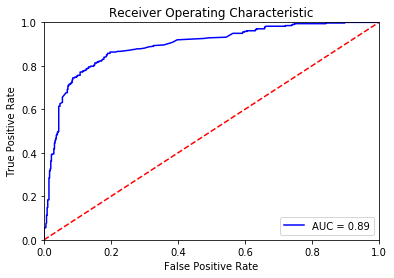

In [26]:
lrRelevant = LogisticRegression()
lrRelevant.fit( X_train_cv, y_train )
predictions = lrRelevant.predict( X_test_cv )

print( 'Accuracy score of Logistic Regression: ', accuracy_score( y_test, predictions ) )
print( 'Precision score of Logistic Regression: ', precision_score( y_test, predictions, pos_label = positiveLabel ) )
print( 'Recall score of Logistic Regression: ', recall_score( y_test, predictions, pos_label = positiveLabel ) )

probs = lrRelevant.predict_proba( X_test_cv )
preds = probs[ :, 1 ]
fpr, tpr, threshold = roc_curve( y_test, preds, pos_label = positiveLabel )
roc_auc = auc( fpr, tpr )

plt.title( 'Receiver Operating Characteristic' )
plt.plot( fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc )
plt.legend( loc = 'lower right') 
plt.plot( [ 0, 1 ], [ 0, 1 ], 'r--' )
plt.xlim( [ 0, 1 ] )
plt.ylim( [ 0, 1 ] )
plt.ylabel( 'True Positive Rate' )
plt.xlabel( 'False Positive Rate' )
plt.show()

In [ ]:
svm = SVC( probability = True )
svm.fit( X_train_cv, y_train )
predictions = svm.predict( X_test_cv )

print( 'Accuracy score of SVM: ', accuracy_score( y_test, predictions ) )
print( 'Precision score of SVM: ', precision_score( y_test, predictions, pos_label = positiveLabel ) )
print( 'Recall score of SVM: ', recall_score( y_test, predictions, pos_label = positiveLabel ) )

probs = svm.predict_proba( X_test_cv )
preds = probs[ :, 1 ]
fpr, tpr, threshold = roc_curve( y_test, preds, pos_label = positiveLabel )
roc_auc = auc( fpr, tpr )

plt.title( 'Receiver Operating Characteristic' )
plt.plot( fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc )
plt.legend( loc = 'lower right') 
plt.plot( [ 0, 1 ], [ 0, 1 ], 'r--' )
plt.xlim( [ 0, 1 ] )
plt.ylim( [ 0, 1 ] )
plt.ylabel( 'True Positive Rate' )
plt.xlabel( 'False Positive Rate' )
plt.show()

In [ ]:
y_train = [ data[ 'CategoryBroad'][ i ] for i in X_trainO.index ]
y_test = [ data[ 'CategoryBroad'][ i ] for i in X_testO.index ]

labels = set( [ value for value in data[ 'CategoryBroad'] ] )
for label in labels:
    print( 'Number of examples in category {0}: {1}'.format( label, len( X_trainO[ ( data[ 'CategoryBroad' ] == label ) ] ) ) )

In [ ]:
naive_bayes = MultinomialNB()
naive_bayes.fit( X_train_cv, y_train )
predictions = naive_bayes.predict( X_test_cv )
print( 'Accuracy score of Naive Bayes: ', accuracy_score( y_test, predictions ) )

lr = LogisticRegression()
lr.fit( X_train_cv, y_train )
predictions = lr.predict( X_test_cv )
print( 'Accuracy score of Logistic Regression: ', accuracy_score( y_test, predictions ) )

svm = SVC( probability = True )
svm.fit( X_train_cv, y_train )
predictions = svm.predict( X_test_cv )
print( 'Accuracy score of SVM: ', accuracy_score( y_test, predictions ) )

In [ ]:
bla = lrRelevant.predict( X_test_cv )
# + F1 score za vse!!!